<a href="https://colab.research.google.com/github/PratyushJha254/Feature-Based-Dynamic-Pricing-Paper-Implementation-Cohen-et-al.-2020-/blob/main/EXP4_with_Noise_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from numba import jit
import math

In [ ]:
seed = 11
np.random.seed(seed)
R = 1

In [ ]:
# @jit(nopython = True)
def plott(regret, T, minD = 0, maxD = 0, fst = True):
  if(fst):
    plt.plot(np.log(np.linspace(1,T,T)), regret)
  else:
    plt.plot(np.linspace(minD,maxD-1, maxD-minD), regret)

In [ ]:
import numpy as np

def find_closest_array(A, B):
    # Initialize minimum distance and the index of the closest array
    min_dist = np.inf
    closest_array = None
    i=0
    # Iterate through each array in A
    for array in A:
        # Calculate the Euclidean distance from the current array to B
        dist = np.linalg.norm(np.array(array) - np.array(B))

        # If this distance is less than the current minimum, update min_dist and closest_array
        if dist < min_dist:
            min_dist = dist
            closest_array = i
        i+=1

    return closest_array

## EXP4 with Noise

In [ ]:
# @jit(nopython=True)
def discretize_vector(d, gamma):
    # Generate a grid of equally spaced values in each dimension
    intervals = np.arange(0, 1, gamma)

    # Generate all combinations of values in each dimension
    grid = np.meshgrid(*[intervals]*d, indexing='ij')

    # Combine the values in each dimension to form vectors
    discretized_vectors = np.vstack([component.flatten() for component in grid]).T

    return discretized_vectors

In [ ]:
@jit(nopython=True)
def weighted_choice(weights):
    cumulative_sum = np.cumsum(weights)
    rnd = np.random.rand() * cumulative_sum[-1]
    return np.searchsorted(cumulative_sum, rnd)

In [ ]:
# #Noise calculation:
# p_star = 0
# ind = 0
# cnts = 0
# for x in act_wts:
#   proba_val = exp(-((x-at)**2)/(2*(sigma**2)))
#   if(p_star<=proba_val):
#     p_star = proba_val
#     ind = cnts
#   cnts++

# #Regret calculation will be difficult since for every policy, noise thing must be calculated; based on this, act_wts will be different now

# #value with noise:
# v = v+del_t

An attempt to code EXP4 with noise, this could not be coded properly because the p* function has amiguity in the paper.

In [ ]:
from numba import jit
from scipy.stats import norm

# @jit(nopython=True)
def EXP4(theta, d, gamma, eta, T,theta_dis, closest_pi):
    size = len(theta_dis)
    w0 = np.ones(size)  # Initialize weights uniformly
    pol_at = np.zeros(size)
    rt_pi = np.zeros(size)
    regret = np.zeros(T)
    rew_prev = 0
    rewards_prev = np.zeros(size)
    exp_reg = np.zeros(T)
    rew_store = np.zeros(size)
    # act_wt = np.zeros(1/(gamma*np.sqrt(d)))
    exp_val = 0
    maxi = 0
    sigma = 0.1
    for t in range(T):
        del_t = abs(np.random.normal(0,sigma))
        xt = np.abs(np.random.uniform(0, 1, d))  # Generate random vector xt
        xt = xt / np.sqrt(np.sum(xt ** 2))
        v = np.dot(theta, xt) + del_t  # Compute inner product of theta and xt
        gd = gamma * np.sqrt(d)
        # Discretize the inner product between theta and xt
        dis_thetax = gd * np.floor(np.dot(theta_dis, xt) / gd)

        # Compute the potential actions based on discretization
        # pol_at = dis_thetax - gd ################################
        pol_at = dis_thetax

        # Choose an action based on the weights w0
        probabilities = w0 / np.sum(w0)
        th_choice = weighted_choice(probabilities)
        at = pol_at[th_choice]

        #Noise calculation:
        # p_star = 0
        # ind = 0
        # for x in act_wts:
        #   proba_val = (x-at)/sigma
        #   proba_val = 1-norm.cdf(proba_val)
        #   proba_val *= x
        #   if(p_star<=proba_val):
        #     p_star = proba_val
        #     ind = x
        # # Compute reward
        rt_at = 1 * (at <= v)
        # rt_at = (ind <= v)

        # Compute reward estimates for all actions
        sum_weights = 0
        for j in range(size):
          if (pol_at[j]==at):
            sum_weights += w0[j]

        for i in range(size):
            if pol_at[i] == at:
                # Compute sum of weights for actions where pol_at[j] == at using a list comprehension
                rt_pi[i] = (rt_at * np.sum(w0)) / sum_weights
            else:
                rt_pi[i] = 0

        prev_m = max(rew_store)

        # Update weights
        # if(rt_at!=0):
        for j in range(size):
          w0[j] = w0[j]*np.exp(eta * (rt_pi[j]))

        act_wts = {}
        for i in range (size):
          actions = pol_at[i]
          rew_store[i] += (actions<=v)
          if actions in act_wts:
            act_wts[actions] += w0[i]
          else:
            act_wts[actions] = w0[i]
        maxi = max(maxi,len(act_wts))
        # act_wts = {}
        # for i in range (size):
        #   actions = pol_at[i]
        #   rew_store[i] += (actions<=v)
        #   if actions in act_wts:
        #     act_wts[actions] += w0[i]
        #   else:
        #     act_wts[actions] = w0[i]
        # maxi = max(maxi,len(act_wts))

        # print(len(act_wts))
        total_wt = np.sum(w0)
        for x in act_wts: ####
          rt_act = (x<=v)
          exp_val += (rt_act*(act_wts[x]))/total_wt



        exp_reg[t] =  max(rew_store)-exp_val
        # rt_at = at*(at<=v)
        regret[t] += regret[max(0,t-1)] + (v-at*(rt_at))

        if((t+1)%1000==0):
            print('t=', t)
            print('Selected Price:', at)
            print('Actual Price:', v)
            # print("th_choice'xt", np.dot(th_choice,xt))
            print('Regret:', exp_reg[t])
            print('Selected Policy', theta_dis[th_choice])

            print('Correct Policy', theta)
            print('Selected Policy Weights', w0[th_choice])
            print('Correct Policy Weights', w0[closest_pi])
            print('--------------------------')
    print(maxi)

    return exp_reg, w0,regret


In [ ]:
d = 2
T = 10000
gamma = 1 / ((T*np.sqrt(d)) ** (1/3))
theta = np.abs(np.random.uniform(0, 1, d))
theta = theta / np.sqrt(np.sum(theta ** 2))
theta_dis = discretize_vector(d, gamma)
size = len(theta_dis)
eta = np.sqrt(2* np.log(size) / (T * (1/(gamma*np.sqrt(d)))))/2

t= 999
Selected Price: 0.350882128585544
Actual Price: 0.7865765672473386
Regret: 117.09992569744975
Selected Policy [0.28946299 0.24811113]
Correct Policy [0.31183503 0.95013626]
Selected Policy Weights 70.69053620638971
Correct Policy Weights 54.163286784747804
--------------------------
t= 1999
Selected Price: 0.0
Actual Price: 0.41708826258992854
Regret: 152.92516555914472
Selected Policy [0.         0.28946299]
Correct Policy [0.31183503 0.95013626]
Selected Policy Weights 5956.758113568268
Correct Policy Weights 4102.596185752431
--------------------------
t= 2999
Selected Price: 0.175441064292772
Actual Price: 0.39548182231718015
Regret: 169.2865087324376
Selected Policy [0.12405557 0.82703711]
Correct Policy [0.31183503 0.95013626]
Selected Policy Weights 1266566.2088425588
Correct Policy Weights 490669.4771917675
--------------------------
t= 3999
Selected Price: 0.350882128585544
Actual Price: 1.0315737385910213
Regret: 434.103293850163
Selected Policy [0.         0.41351855]

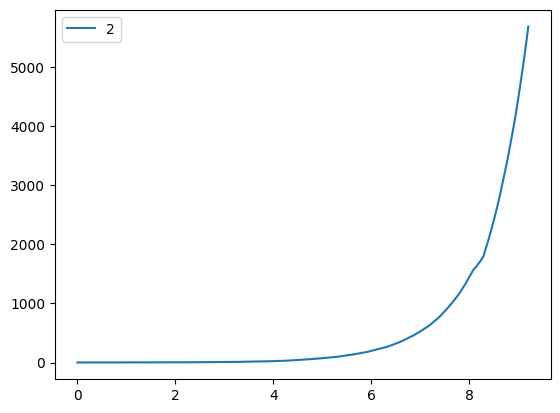

In [ ]:
closest_pi = find_closest_array(theta_dis, theta)
regret2, w0,reggi = EXP4(theta, d, gamma, eta, T,theta_dis, closest_pi)
plt.plot(np.log(range(1,T+1)),reggi, label=2)
# plt.plot(np.log(range(1,T+1)),regret3, label=3)
plt.legend()

In [ ]:
reggi[T-1]

5694.248249479634

## Ellipsoid Pricing With Noise

In [ ]:
@jit(nopython=True)
def EllipsoidPricing(ep, theta, d, T):
    num_explore = np.zeros(T)
    at = np.zeros(d, dtype=np.float64)
    At = np.eye(d, dtype=np.float64)
    rev = 0
    regret = np.zeros(T)
    for i in range(T):
        del_t = 0
        xt = np.random.normal(0, 1, d)
        xt = xt / np.sqrt(np.sum(xt ** 2))
        xt = np.abs(xt)
        dell = np.sqrt(xt.T @ At @ xt)
        bt_min = xt.T @ at - dell
        bt_max = xt.T @ at + dell
        delta = 2 * dell
        v = theta.T @ xt
        pt = 0
        if delta <= ep:
            pt = bt_min
            rev += pt
        else:
            num_explore[i] = 1
            b = (At @ xt) / dell
            pt = (bt_min + bt_max) / 2
            bb = (b[:, np.newaxis] @ b[np.newaxis, :])
            At = ((d ** 2) / (d ** 2 - 1)) * (At - (2 / (d + 1)) * bb)
            if pt <= v:
                rev += pt
                at = at + b / (d + 1)
            else:
                rev += 0
                at = at - b / (d + 1)

        reg = v - (pt * (pt <= v))

        if i == 0:
            regret[i] = reg
        else:
            regret[i] = regret[i - 1] + reg

    return regret, num_explore


In [ ]:
@jit(nopython = True)
def ExpectedValue_EllipsoidPricing(ep, theta, d, T, epochs):
  regret = np.zeros(T)
  explore = np.zeros(T)
  for i in range(epochs):
    regret_temp, explore_temp = EllipsoidPricing(ep, theta, d, T)
    regret += regret_temp
    explore +=explore_temp

  regret = regret/epochs
  explore = explore/epochs
  return regret, explore

In [ ]:
# @jit(nopython = True)
def plott(regret, T, minD = 0, maxD = 0, fst = True):
  if(fst):
    plt.plot(np.log(np.linspace(1,T,T)), regret)
  else:
    plt.plot(np.linspace(minD,maxD-1, maxD-minD), regret)

31.151113774512982


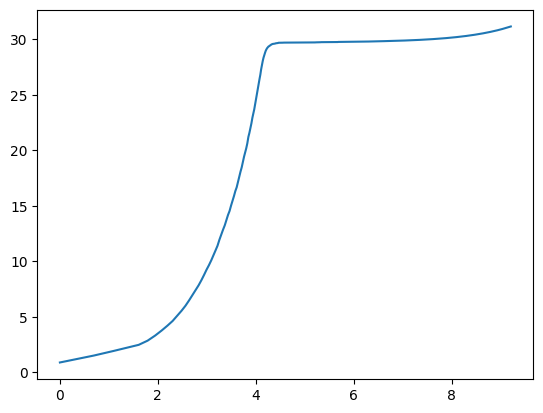

In [ ]:
# graph_1
dimensions = [2]
for d in dimensions:
  T=10000
  ep = R*(d**2)/T
  theta = np.random.normal(0,1,d)
  theta = theta/np.sqrt(np.sum(theta**2))
  theta = np.abs(theta)
  epochs = 100
  regret, _ = ExpectedValue_EllipsoidPricing(ep, theta, d, T, epochs)
  print(regret[T-1])
  plott(regret, T)

In [ ]:
print(reggi[T-1]- 4936.94)

757.3082494796345


# Shallow Pricing With Noise

In [ ]:
@jit(nopython=True)
def ShallowPricing(theta, d, T):
    num_explore = np.zeros(T)
    at = np.zeros(d, dtype=np.float64)
    At = np.eye(d, dtype=np.float64)
    rev = 0
    sigma = 0.1
    # sigma = 1/(T*np.log(T))
    DELTA = np.sqrt(2)*sigma*np.log(T)
    regret = np.zeros(T)
    for i in range(T):
        DELTA_t = abs(np.random.normal(0,sigma))
        # DELTA_t = min(DELTA_t, DELTA)
        xt = np.random.normal(0, 1, d)
        xt = xt / np.sqrt(np.sum(xt ** 2))
        xt = np.abs(xt)
        dell = np.sqrt(xt.T @ At @ xt)
        bt_min = xt.T @ at - dell
        bt_max = xt.T @ at + dell
        delta = 2 * dell
        ALPHA_t = max(-DELTA/dell, -1/d)
        v = theta.T @ xt + DELTA_t
        pt = 0
        if delta <= ep:
            pt = bt_min - DELTA
            rev += pt
        else:
            num_explore[i] = 1
            b = (At @ xt) / dell
            pt = (bt_min + bt_max) / 2 - DELTA
            bb = (b[:, np.newaxis] @ b[np.newaxis, :])
            At = ((d ** 2) / (d ** 2 - 1)) * (1 - ALPHA_t ** 2)  * (At - ((2  * (1 + d * ALPHA_t)) / ((1 + ALPHA_t) * (d + 1))) * bb)
            if pt <= v:
                rev += pt
                at = at + (1 + d*ALPHA_t) * b / (d + 1)
            else:
                rev += 0
                at = at - (1 + d * ALPHA_t) * b / (d + 1)

        reg = v - (pt * (pt <= v))

        if i == 0:
            regret[i] = reg
        else:
            regret[i] = regret[i - 1] + reg

    return regret, num_explore


In [ ]:
d = 2
T=50000
R=1
# sigma = 1/(T*np.log(T))
sigma = 0.1
ep = R*(d**2)/T
DELTA = np.sqrt(2)*d*sigma
ep = max(ep, 4*d*DELTA)
theta = np.random.normal(0,1,d)
theta = theta/np.sqrt(np.sum(theta**2))
theta = np.abs(theta)
epochs = 100
regret3, explore = ShallowPricing(theta, d, T)

In [ ]:
print(reggi[T-1]-regret3[T-1])

IndexError: index 49999 is out of bounds for axis 0 with size 10000

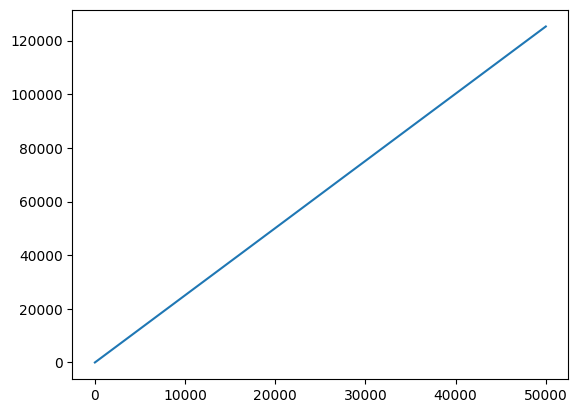

In [ ]:
plt.plot(range(0,T), regret3)
# plt.plot(range(0,T),reggi)